In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List
import datamol as dm
from medchem.query.eval import QueryFilter


In [3]:
query = """HASPROP("tpsa" < 120) AND HASSUBSTRUCTURE("[OH]", True)"""
chemical_filter = QueryFilter(query, parser="lalr")

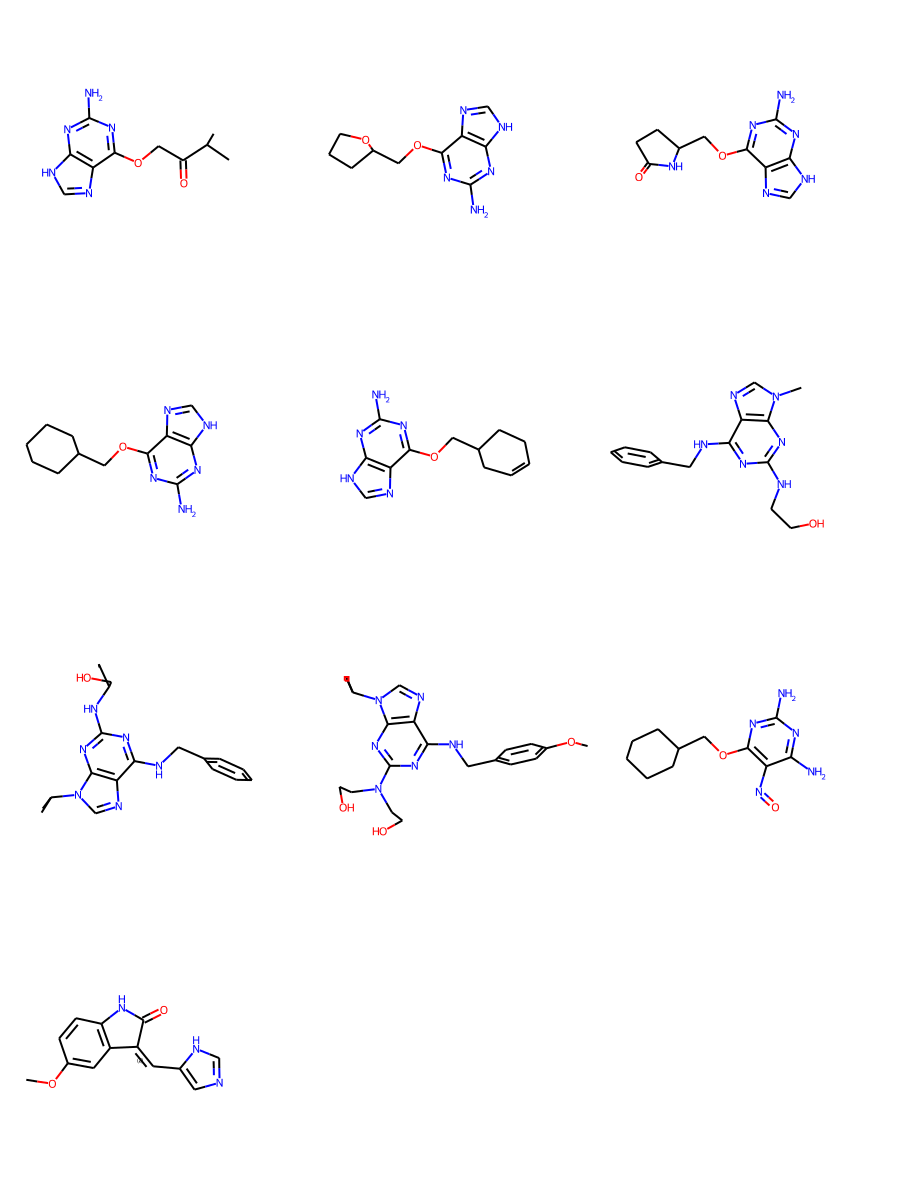

In [45]:
mols = dm.data.cdk2().mol[:10]
dm.to_image(mols, n_cols=3)

In [46]:
chemical_filter(mols, n_jobs=1)

100%|██████████| 10/10 [00:00<00:00, 3174.62it/s]


[False, False, False, False, False, True, True, True, False, False]

In [4]:
chemical_filter

((`fn(getprop, prop='tpsa')` < 120.0) and `fn(hassubstructure, query='[OH]', is_smarts=True, operator=None, limit=None)`)

In [5]:
queries = [
            """HASPROP("tpsa" > 120) OR ! HASSUBSTRUCTURE("CO")""",  # A OR ! B
            """(HASPROP("tpsa" > 120)) OR ! (HASSUBSTRUCTURE("CO"))""",  # (A) OR  ! (B)
            """(HASPROP("tpsa" > 120) OR ! HASSUBSTRUCTURE("CO"))""",  # (A OR ! B)
            """HASPROP("tpsa" > 120) OR NOT HASSUBSTRUCTURE("CO")""",  # A OR NOT B
            """HASPROP("tpsa" > 120) OR ~HASSUBSTRUCTURE("CO")""",  # A OR ~B
            """HASPROP("tpsa" >   120)   OR ! HASSUBSTRUCTURE("CO")""",  # change in space
        ]

In [118]:
from lark import Lark, Transformer, v_args
from medchem.utils.loader import get_grammar
from medchem.query.parser import QueryParser

grammar = Lark(get_grammar(as_string=True), parser="lalr", transformer=QueryParser())

In [138]:
queries = [
            # complex query
            """(HASPROP("tpsa" < 100) AND HASPROP("clogp" < 3) AND ! HASALERT("pains")) OR (HASPROP("n_heavy_atoms" >= 10) AND (HASGROUP("Alcohols") OR HASSUBSTRUCTURE("[CX3](=[OX1])O", True, 1)))""",
            # is a rewriting of the above
            """(HASPROP("tpsa" < 100) AND HASPROP("clogp" < 3) AND ! HASALERT("pains")) OR (HASPROP("n_heavy_atoms" >= 10) AND (HASGROUP("Alcohols") OR HASSUBSTRUCTURE("[CX3](=[OX1])O", True, min, 1)))""",
            # is a rewriting of the above with spacing and a differentm yet equivalent bool expression
            """
            (
                HASPROP("tpsa" < 100) 
                AND 
                HASPROP("clogp" < 3) 
                AND 
                ! HASALERT("pains")
            ) 
            OR 
            (
                HASPROP("n_heavy_atoms" >= 10) 
                AND 
                HASGROUP("Alcohols")
            ) 
            OR 
            (
                HASPROP("n_heavy_atoms" >= 10) 
                AND 
                HASSUBSTRUCTURE("[CX3](=[OX1])O", True)
            )
            """,
            # always true
            """(HASPROP("tpsa" < 100) AND HASPROP("clogp" < 3)) OR TRUE""",
            # always false
            """(HASPROP("tpsa" < 100) AND HASPROP("clogp" < 3)) AND False""",
]
out = [grammar.parse(queries[i]) for i in range(len(queries))]

In [139]:
out

["(((`fn(getprop, prop='tpsa')` < 100.0) and (`fn(getprop, prop='clogp')` < 3.0) and not `fn(hasalert, alert='pains')`) or ((`fn(getprop, prop='n_heavy_atoms')` >= 10.0) and (`fn(hasgroup, group='Alcohols')` or `fn(hassubstructure, query='[CX3](=[OX1])O', is_smarts=True, operator=None, limit=1)`)))",
 "(((`fn(getprop, prop='tpsa')` < 100.0) and (`fn(getprop, prop='clogp')` < 3.0) and not `fn(hasalert, alert='pains')`) or ((`fn(getprop, prop='n_heavy_atoms')` >= 10.0) and (`fn(hasgroup, group='Alcohols')` or `fn(hassubstructure, query='[CX3](=[OX1])O', is_smarts=True, operator='min', limit=1)`)))",
 "(((`fn(getprop, prop='tpsa')` < 100.0) and (`fn(getprop, prop='clogp')` < 3.0) and not `fn(hasalert, alert='pains')`) or ((`fn(getprop, prop='n_heavy_atoms')` >= 10.0) and `fn(hasgroup, group='Alcohols')`) or ((`fn(getprop, prop='n_heavy_atoms')` >= 10.0) and `fn(hassubstructure, query='[CX3](=[OX1])O', is_smarts=True, operator=None, limit=None)`))",
 "(((`fn(getprop, prop='tpsa')` < 100.0)

In [57]:
[out[i] == out[0] for i in range(len(out))]

[True, True, True, True, True, True, True, True, True, True]

In [125]:
bad_queries = [
    "(((HASPROP(tpsa > 120 ) | HASSUBSTRUCTURE(c1ccccc1)) AND NOT HASALERT(pains)) OR HASSUBSTRUCTURE([OH]))",
    """HASPROP("tpsa" > 120 ) OR OR HASSUPERSTRUCTURE("Cc1cc2ccccc2cc1C")""",
    """HASPROP("tpsa" > 120 ) OR HASSUPERSTRUCTURE("Cc1cc2ccccc2cc1C") OR NOT TRUE""",
    """HASPROP("tpsa" > 120 ) OR HASSUPERSTRUCTURE("Cc1cc2ccccc2cc1C") OR true""",
    """HASPROP("tpsa" > 120 ) OR HASSUPERSTRUCTURE("Cc1cc2ccccc2cc1C") TRUE""",  # wrong syntax, UnexpectedCharacters
    """HASPROP("tpsa" > 120 ) OR  (HASSUPERSTRUCTURE("Cc1cc2ccccc2cc1C")""",
    """HASPROP("tpsa" > 120 ) OR () OR HASSUPERSTRUCTURE("Cc1cc2ccccc2cc1C")""",
    """HASPROP("tpsa" > 120) OR HASSUBSTRUCTURE("[OH]", True, >, 3)""",
    """HASPROP("tpsa" + 120) OR HASSUBSTRUCTURE("[OH]")""",
    """HASPROP("tpsa", >, 120) OR HASSUBSTRUCTURE("[OH]")""",
    """HASPROP("tpsa" > 120) OR HASSUBSTRUCTURE("[OH]" True max 3)""",
    """HASPROP("tpsa" > 120) OR HASSUBSTRUCTURE("[OH]", True, 3)""",
    """(
            HASPROP("tpsa" < 100) AND 
            HASPROP("clogp" < 3) AND 
            ! HASALERT("pains")
        ) 
        OR 
        (
            HASPROP("n_heavy_atoms" >= 10) AND 
            HASGROUP("Alcohols")
        ) 
        OR 
        (
            HASPROP("n_heavy_atoms" >= 10) AND 
            HASSUBSTRUCTURE("[CX3](=[OX1])O", True)
        )""",
    """(HASPROP("tpsa" < 100) AND HASPROP("clogp" < 3) AND ! HASALERT("pains")) OR (HASPROP("n_heavy_atoms" >= 10) AND (HASGROUP("Alcohols") OR HASSUBSTRUCTURE("[CX3](=[OX1])O", True, min, 1)))""",
]

In [137]:
from medchem.query import QueryOperator
df = dm.cdk2()
df["tpsa"] = df["mol"].apply(dm.descriptors.tpsa)
df["clogp"] = df["mol"].apply(dm.descriptors.clogp)
df["n_heavy_atoms"] = df["mol"].apply(dm.descriptors.n_heavy_atoms)
df["has_carboxyl"] = df["mol"].apply(
    lambda x: QueryOperator.hassubstructure(x, "[CX3](=[OX1])O", True)
)
df["has_pains"] = df["mol"].apply(lambda x: QueryOperator.hasalert(x, "pains"))
df["has_alcohol"] = df["mol"].apply(
    lambda x: QueryOperator.hasgroup(x, "Alcohols")
)

tmp = df.query(
    "((tpsa < 100) & (clogp < 3) & ~has_pains) | (n_heavy_atoms >= 10 & (has_carboxyl | has_alcohol))"
)
df["results"] = False
df.loc[tmp.index, "results"] = True

In [135]:
expected_complex_result.index

Int64Index([1, 3, 4, 5, 6, 7, 9, 10, 12, 14, 16, 18, 20, 22, 25, 34, 35, 36,
            41],
           dtype='int64')

In [92]:
mol = dm.to_mol("Oc1cscc1-c1ccc(OC)cc1") # contains tiophene hydroxy should match pains
substruct1 = dm.to_mol("CO")
mol.GetSubstructMatches(substruct1, uniquify=True)

((1, 0), (9, 10), (11, 10))

In [93]:
from medchem.rules.rule_filter import RuleFilters

In [94]:
r = RuleFilters(["rule_of_five", "rule_of_three"])
r([mol])

,0,1
0,True,False


In [96]:
from medchem.groups import _get_functional_group_map

In [97]:
d = _get_functional_group_map()

In [108]:
[x for x in d.keys() if 'hydroxy' in x.lower()]

['Hydroxy compounds: alcohols or phenols', 'Hydroxylamines', 'α-Hydroxyacids']